# Lab. 3: GD, Newton methods and BFGS

## Introduction

#### <u>The goal of this laboratory is to study the application of local search algorithms on different benchmark functions.</u>

We will study three methods:
- *Gradient Descent*
- *Newton methods*
- *BFGS*

Moreover, we will study how their parameters change the behavior of these algorithms.

---

Getting started: the following code cell contains the core functions that we will use. Hence, **remember to run it every time the runtime is reconnected**.

It contains the three local search algorithms and a wrapper class called *OptFun* for the benchmark function.
As regards the *OptFun* class, the constructor takes as input a benchmark function (we will see later what functions are available). The relevant methods  are 4:
1.   *Minima*: return the minimum of the function. The position can be obtained by the parameter *position* and the function value from the *score* parameter.
2.   *Bounds*: returns where the function is defined
3.   *Heatmap*: show a heatmap of the function highlighting the points visited by the local search (use with 2d function)
4.   *plot*: show the trend of the points visited by the local search (use with 1d function)
5.   *trend*: show the best points find during the optmization process.

Each instance of *OptFun* stores the history of the point at which the function has been evaluated. The history is never cleaned and can be obtained through *OptFun.history*. Hence, if you reuse the class instance remember to clean the history (*OptFun.history = list()*).

---

The benchmark functions available comes from the *benchmark_functions* library (imported as *bf*).
Example of the functions that can be used are the *Hypersphere*, the *Rastrign* the *DeJong5* and the Keane.
The complete list of functions available can be found at this [link](https://gitlab.com/luca.baronti/python_benchmark_functions) or printing *dir(bf)*.

#### Base code to run every time the runtime is reconnected

In [1]:
%%capture

try:
  import benchmark_functions as bf
  import numdifftools as nd
except:  # colab env
  !pip install benchmark_functions
  !pip install numdifftools
  import benchmark_functions as bf
  import numdifftools as nd

from scipy.optimize import minimize, rosen, approx_fprime
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
from scipy.misc import derivative
import inspect

plt.rcParams["figure.figsize"] = (8,5)

In [2]:
class OptFun():
    def __init__(self, wf):
        self.f = wf
        self.history = []

    def __call__(self, x0):
        self.history.append(deepcopy(x0))
        return self.f(x0)

    def minima(self):
        """
        Returns a list of Optimum objects of the known global minima. If there aren't any minima, an empty list value will be returned instead;

        Returns:
        - List of objects of class "benchmark_functions.functions_info_loader.Optimum"
        - For each object:
          - Access to 'position' parameter to get the axis values
          - Access to 'score' parameter to get the value of the function
        """
        return self.f.minima()

    def bounds(self):
        return self._convert_bounds(self.f.suggested_bounds())

    def heatmap(self, fn = None):
        plt.clf()
        resolution = 50
        fig = plt.figure()
        fig.canvas.manager.set_window_title('Benchmark Function: '+self.f._name)
        fig.suptitle(self.f._name)
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
        if self.f._n_dimensions>1:
            y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray([[self.f((X[i][j],Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])

        plt.contour(x,y,Z,15,linewidths=0.5,colors='k') # hight lines
        plt.contourf(x,y,Z,15,cmap='viridis', vmin=Z.min(), vmax=Z.max()) # heat map
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar()
        cbar.set_label('z')
        if len(self.history)>0:	# plot points
            xdata = [x[0] for x in self.history]
            ydata = [x[1] for x in self.history]
            plt.plot(xdata[0], ydata[0], "Xr", markersize=13)
            plt.plot(xdata, ydata, "or-", markersize=5, linewidth=1.5)
            plt.plot(xdata[-1], ydata[-1], "Pr", markersize=13)
        if fn is None:
            plt.show()
        else:
            plt.savefig(fn, dpi=400)

    def plot(self):
        plt.clf()
        values = [self.f(v) for v in self.history]
        min = func.minima()[0].score

        plt.plot(values, label="trend of found points")

        plt.axhline(min, color="r", label="optimum")
        plt.xlabel('Function evaluations')
        plt.ylabel('f(x)')
        plt.legend()
        plt.show()

    def _convert_bounds(self, bounds):
        new_bounds= []
        for i in range(len(bounds[0])):
            new_bounds.append((bounds[0][i], bounds[1][i]))
        return new_bounds

    def current_calls(self):
        return len(self.history)

    def gradient(self, x):
      return approx_fprime(x, self.f, epsilon=1.4901161193847656e-08)

def gradient_descent(f, x0, learn_rate, n_iter=50, tolerance=1e-06):
    x = x0
    f.history.append([v for v in x])
    for _ in range(n_iter):
        diff = -learn_rate * f.gradient(x)
        if np.all(np.abs(diff) <= tolerance):
            break
        x += diff
        f.history.append([v for v in x])

    return x

def newton_method(f, x0, n_iter=50, tolerance=1e-06):
    x = np.array(x0)
    f.history.append(x.copy())
    f_jacob = nd.Jacobian(f.f)
    f_hess = nd.Hessian(f.f)
    for _ in range(n_iter):
        JA = f_jacob(x)
        HA = np.linalg.inv(f_hess(x))
        diff = -1*(JA.dot(HA)[0])
        if np.all(np.abs(diff) <= tolerance):
            break
        x += diff
        f.history.append(x.copy())
    return x


def bfgs(f: OptFun, x0, eps: float, maxiter: int):
     """
     Optimizes a function by using the BFGS algorithm.

     - f: function to optimize, an instance of OptFun
     - x0: starting point for the search process
     - eps: step size for the update of the jacobian
     - maxiter: maximum number of iterations
     """
     return minimize(
         f,
         x0,
         method='BFGS',
         jac=None,
         options={
             'gtol': 1e-05,
             'norm': float('inf'),
             'eps': eps,
             "maxiter": maxiter,
             'disp': False,
             'return_all': True,
             'finite_diff_rel_step': None
         }
     )

In [3]:
def printClassInitArgs(class_obj):
    print(f'{class_obj.name()}')
    signature = inspect.signature(class_obj.__init__).parameters
    print("-------------------------------")
    for name, parameter in signature.items():
        if name != 'opposite':
            print("Name: ", name, "\nDefault value:", parameter.default)
            #print("Annotation:", parameter.annotation, "\nKind:", parameter.kind)
            print("-------------------------------")

# Exercises

#### Solve the following exercises, and answer these questions at the end:

- What is the difference in search cost (the number of function/derivative evaluations) between these methods?
- Comparing these methods to the ones of the first laboratory, are they faster? Or find the optimal more efficiently?

In [ ]:
# BE AWARE: check the arguments each benchmark function takes
# if you're not sure, you can check the arguments by using the printClassInitArgs function

printClassInitArgs(bf.Hypersphere())

Hypersphere
-------------------------------
Name:  n_dimensions 
Default value: 2
-------------------------------


## Exercise 1/3: GRADIENT DESCENT
In this first exercise, we will focus on the Gradient Descent algorithm.
The gradient descent function parameters are
1.   *f*: the function to minimize
2.   *x0*: the starting point
3.   *learn_rate*: the learning rate
4.   *n_iter*: maximum number of iterations
5.   *tolerance*: the tolerance for finding the optimum (minimum step to move towards the optimum, if the step is lower than this threshold, the search stops)

### Questions
- How does the Learning Rate influence optimization?
- How does tolerance influence the search?
- Are the effects of these parameters the same across different functions?

Bounds: [(-5.0, 5.0), (-5.0, 5.0)]
Best location: [-0.79459541 -0.79459541]


<Figure size 800x500 with 0 Axes>

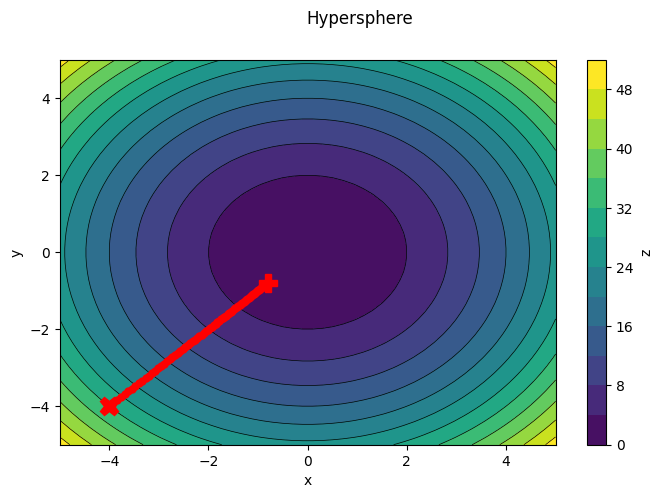

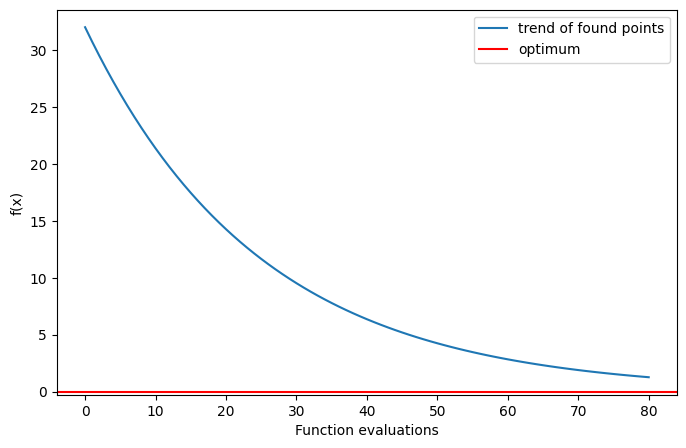

In [13]:
bench_func = bf.Hypersphere(n_dimensions=2)  # TODO: try differenct benchmark function
func = OptFun(bench_func)
print("Bounds:", func.bounds())

x0 = [-4, -4]  # set appropriate to the benchmark function, TODO: try different starting points
lr = 0.01  # TODO: try different values of learning rate
n_iter = 80  # TODO: try different values of number of iterations
tolerance = 0.0001  # TODO: try different values of tolerance

res = gradient_descent(func, x0, lr, n_iter, tolerance)
print("Best location:", res)

func.heatmap()
func.plot()

## Exercise 2/3: NEWTON METHOD
In this exercise, we will see the Newton method.
The Newton Method function parameters are
1.   *f*: the function to minimize
2.   *x0*: the starting point
3.   *n_iter*: maximum number of iterations
4.   *tolerance*: the tolerance for finding the optimum (minimum step to move towards the optimum, if the step is lower than this threshold, the search stops)

### Questions
- Is it faster to converge with respect to GD?
- How does tolerance influence the search?
- Are the results similar across different functions?

Bounds: [(-5.0, 5.0), (-5.0, 5.0)]
Best location: [-1.11022302e-15 -4.88498131e-15]


<Figure size 800x500 with 0 Axes>

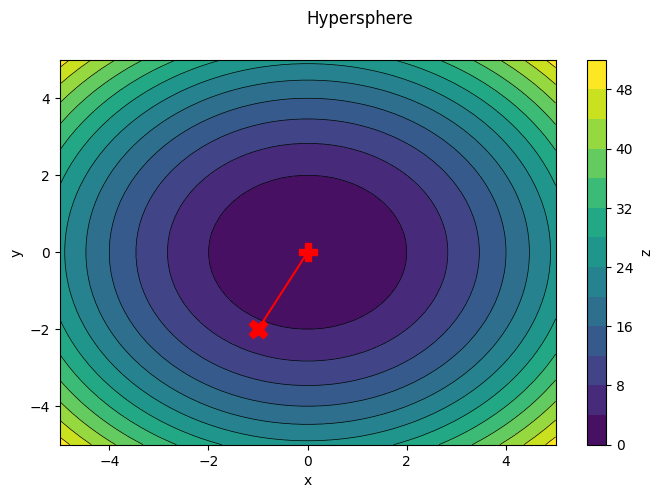

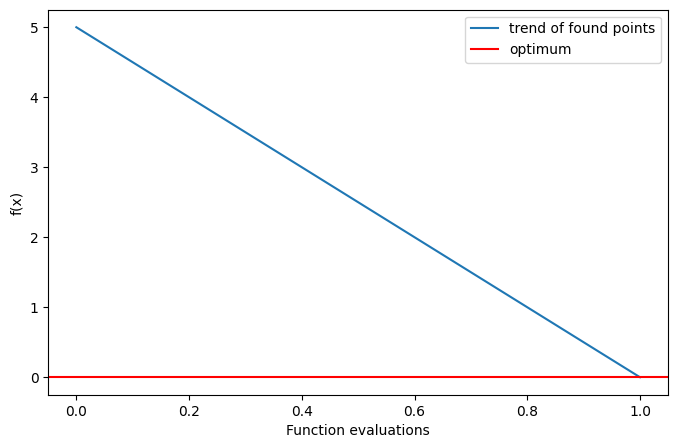

In [16]:
bench_func = bf.Hypersphere(n_dimensions=2)  # TODO: try differenct benchmark function
func = OptFun(bench_func)
print("Bounds:", func.bounds())

x0 = [-1., -2.]  # set appropriate to the benchmark function, TODO: try different starting points
n_iter = 100  # TODO: try different values of number of iterations
tolerance = 0.01  # TODO try different values of tolerance

res = newton_method(func, x0, n_iter, tolerance)
print("Best location:", res)

func.heatmap()
func.plot()

## Exercise 3/3: BFGS OPTIMIZATION
In this exercise, we will focus on the BFGS optimization algorithm.
The BFGS function parameters are
1.   *f*: the function to minimize
2.   *x0*: the starting point
3.   *eps*: step size for the update of the jacobian
4.   *max_iter*: maximum number of iterations

### Questions
- What does it happen by varying these parameters?
- How do they influence the evolution process?
- What is the difference between BFGS and L-BFGS? Hint: you have to change the BFGS function, calling the right method to minimize. See [here](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb) the parameters available.

Bounds: [(-5.0, 5.0), (-5.0, 5.0)]
Best value: 5.68626899491454
Best location: [-1.68615969 -1.68615969]


<Figure size 800x500 with 0 Axes>

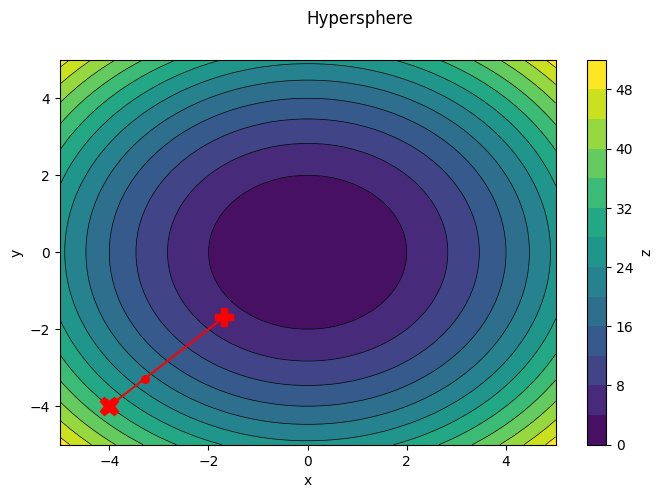

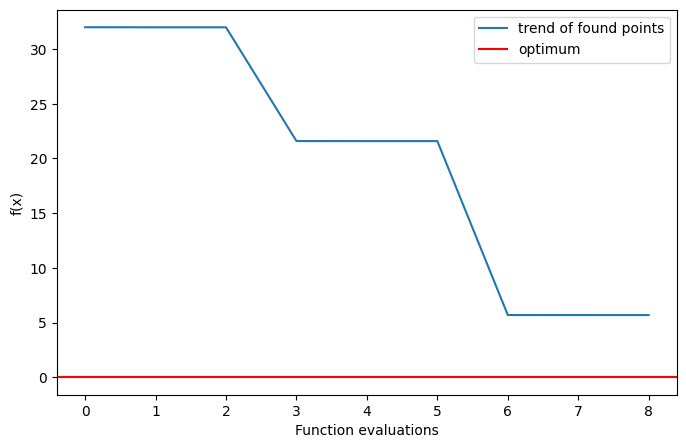

In [17]:
bench_func = bf.Hypersphere(n_dimensions=2)  # TODO: try differenct benchmark function
func = OptFun(bench_func)
print("Bounds:", func.bounds())

x0 = [-4., -4.]  # set appropriate to the benchmark function
eps = 0.001  # TODO: try different values
maxiter = 2  # TODO: try differeent values

res = bfgs(func, x0, eps, maxiter)
best_value, best_location = res['fun'], res['x']
print("Best value:", best_value)
print("Best location:", best_location)

func.heatmap()
func.plot()

## Final questions
- What is the difference in search cost (the number of function/derivative evaluations) between these methods?
- Comparing these methods to the ones of the first laboratory, are they faster? Or find the optimal more efficiently?  

In [ ]:
# TODO